#Recurrent Neural Network from Scratch for Name Classification

- RNNs allow previous outputs to be used as inputs while having hidden states

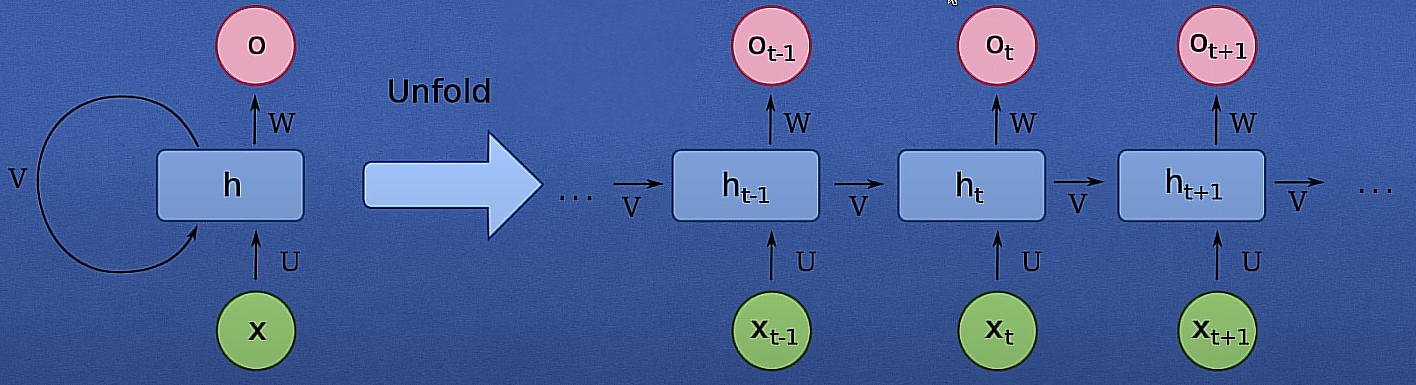

- RNNs allow us to operate over sequences of vectors

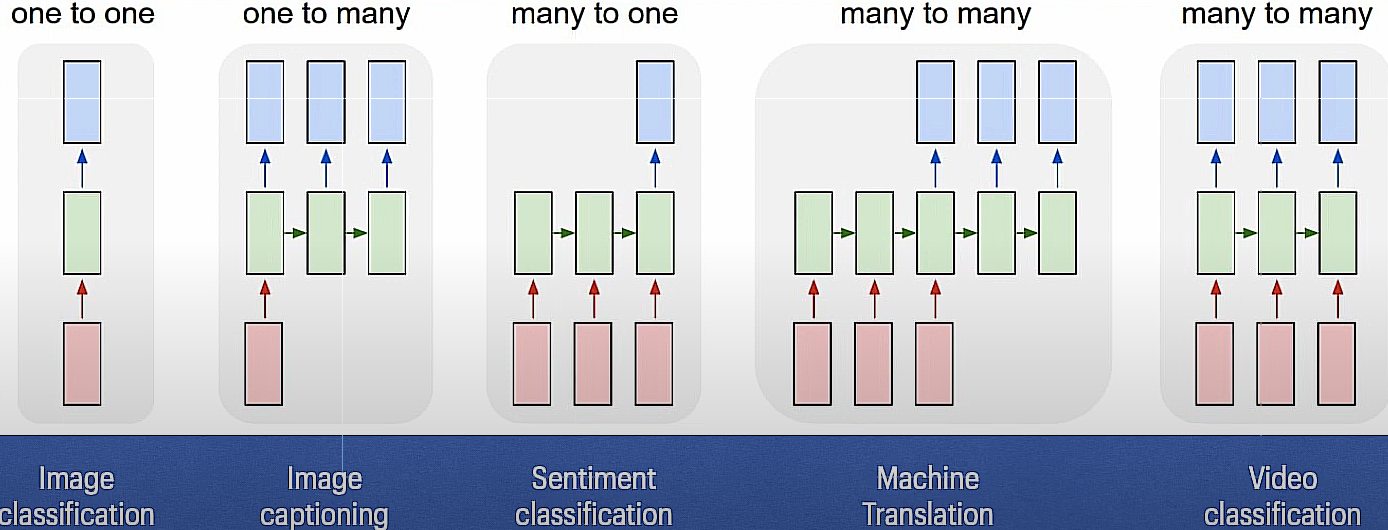

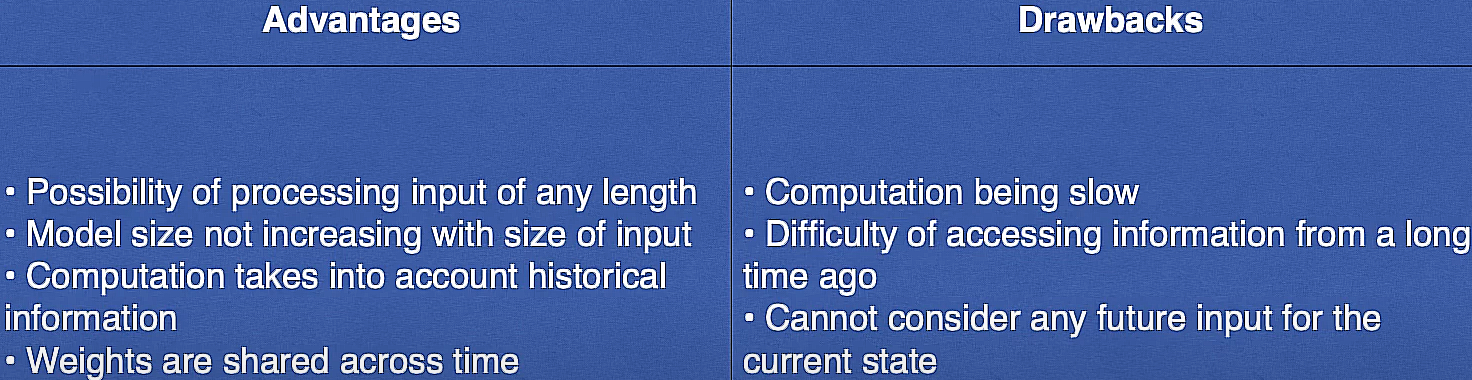

#Importing libraries:

In [1]:
import io
import os
import unicodedata
import string
import glob
import random
import requests
import zipfile
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#Download dataset:

In [2]:
# dataset url
url = "https://download.pytorch.org/tutorial/data.zip"

In [3]:
# directory path to save file
data_dir = "./"
os.makedirs(data_dir, exist_ok=True)

In [4]:
# file path to save the ZIP file
zip_path = os.path.join(data_dir, "data.zip")

In [5]:
# Download file
print("Downloading file...")
response = requests.get(url)

with open(zip_path, "wb") as file:
    file.write(response.content)
print("Download complete.")

Download complete.


In [6]:
# Extract the ZIP file
print("Extracting files...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)
print("Extraction complete.")

Extracting files...
Extraction complete.


#Data Transformation:

In [7]:
# All possible letters = alphabet small + capital letters + ".,:"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)
print(N_LETTERS)

57


In [8]:
#Converting data to ASCII
#turn a unicode string to plain ascii
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s) #converts s into decomposed form i.e. "é" becomes "e"

      if unicodedata.category(c) != "Mn" #checks unicode category of each character.
      #Mn represents Mark Nonspacing, characters in this category are excluded

      and c in ALL_LETTERS
      #ensures that only characters present in ALL_LETTERS are included in output
  )

#Load Data:

In [9]:
#for loading data:

def load_data():

  #Build catergory_lines dictionary, a list of names per language
  category_lines = {}
  all_categories = []

  def find_files(path):
    return glob.glob(path) #searches all files that match the path pattern

  #read a file and split into lines:
  def read_lines(filename):
    lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

  for filename in find_files('data/names/*.txt'): #iterate through each '.txt' file in data/name folder

    category = os.path.splitext(os.path.basename(filename))[0] #stores file name but without the extensions

    all_categories.append(category) #adds category name to all_categories list

    lines = read_lines(filename) #reads all lines from the file

    category_lines[category] = lines #saves all names for the category in the category_lines 2D list

  return category_lines, all_categories

#Convert Data to Tensors:

In [ ]:
"""
Using one hot encoded vector to represent letters.
Example: for letter b the vector will be:
"b" = <0 1 0 0 0 ...>
size of vector will be <1 x n_letters>

To make a word, we will join multiple vectors into a 2D matrix:
<line_length x 1 x n_letters>

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

'\nUsing one hot encoded vector to represent letters. \nExample: for letter b the vector will be:\n"b" = <0 1 0 0 0 ...>\nsize of vector will be <1 x n_letters>\n\nTo make a word, we will join multiple vectors into a 2D matrix:\n<line_length x 1 x n_letters>\n\nThat extra 1 dimension is because PyTorch assumes\neverything is in batches - we’re just using a batch size of 1 here.\n'

In [10]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

In [11]:
#turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

In [12]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

#Picking Random Data:

In [13]:
def random_training_example(category_lines, all_categories):

    def random_choice(a): #selects a random item from a
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories) #picks a random category from all_categories list

    line = random_choice(category_lines[category]) #picks a random line from the random picked category

    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) #converts selected category into pytorch tensor

    line_tensor = line_to_tensor(line) #converts choosen line into a tensor using line_to_tensor function

    return category, line, category_tensor, line_tensor

In [14]:
if __name__ == '__main__': #ensures that this runs only when executed directly and not when imported as a module
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))

    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5]) #displays first five names from italian category

    print(letter_to_tensor('J')) # size: [1, 57], (26 small + 26 capital + 5 symbols = 57 letters)

    print(line_to_tensor('Jones').size()) # size: [5, 1, 57] (Jones = 5, 1 is batch size, 57 = total letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


#RNN Implementation:

- RNN Architecture for Name Classification:

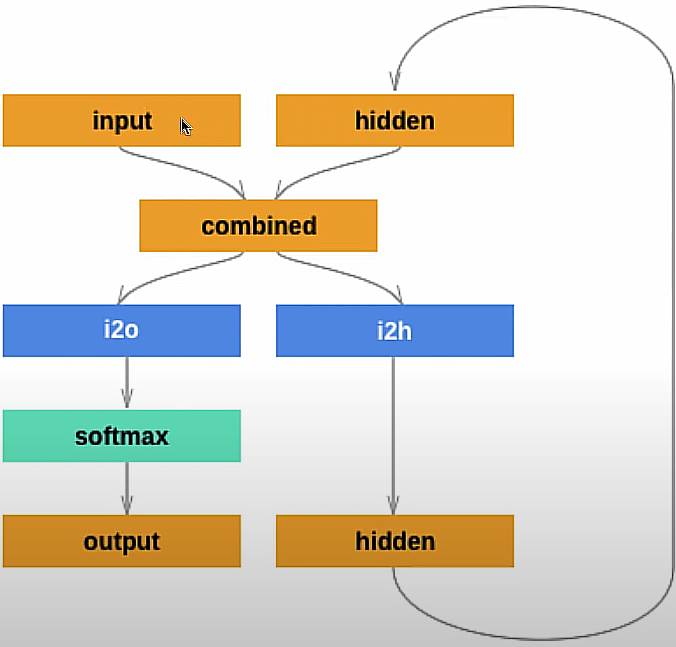

In [20]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #i2h is input to hidden layer
    # input = input_size + hidden_size, output = hidden_size

    self.i2o = nn.Linear(input_size + hidden_size, output_size) #i2h is input to output layer

    self.softmax = nn.LogSoftmax(dim=1) #dimension = 1 because input shape is 1, 57

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1) #combines the two tensors along dimension 1

    hidden = self.i2h(combined)

    output = self.i2o(combined)

    output = self.softmax(output)

    return output, hidden

  def init_hidden(self): #for initial hidden state
    return torch.zeros(1, self.hidden_size)

In [24]:
def category_from_output(output):
  category_idx = torch.argmax(output).item() #return index with highest value
  return all_categories[category_idx]

In [17]:
#loading data
category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(n_categories) #18

18


In [18]:
n_hidden = 128 #Hyperparameter

In [21]:
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [22]:
#for one letter
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size()) #1, 18
print(next_hidden.size()) #1, 128

torch.Size([1, 18])
torch.Size([1, 128])


In [25]:
#for sequence of letters (do repeatedly for each letter)
input_tensor = line_to_tensor("Albert")
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size()) #1, 18
print(next_hidden.size()) #1, 128
print(category_from_output(output))

torch.Size([1, 18])
torch.Size([1, 128])
Scottish


In [26]:
#setting up criterion and optimizer:
criterion = nn.NLLLoss() #Negative Log Likelihood Loss

learning_rate = 0.005

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

#Training:

In [27]:
#training function:
def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden) #giving prev hidden state to model, and storing new output hidden state

  loss = criterion(output, category_tensor) #calculate loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, loss.item()

In [28]:
#training loop
current_loss = 0
all_losses = []

plot_steps, print_steps = 1000, 5000

n_iters = 100000

for i in range(n_iters):
  category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

  output, loss = train(line_tensor, category_tensor)

  current_loss += loss

  if (i+1) % plot_steps == 0:
    all_losses.append(current_loss / plot_steps)
    current_loss = 0

    if (i+1) % print_steps == 0:
      guess = category_from_output(output)
      correct = "CORRECT" if guess == category else f"WRONG, Actual Category:({category})"
      print(f"Step: {i+1}, Loss: {loss:.4f}, Name: {line}, Category: {guess}, Prediction: {correct}")

Step: 4999, Loss: 2.7729, Name: O'Dowd, English WRONG (Irish)
Step: 9999, Loss: 0.3053, Name: Antonopoulos, Greek CORRECT
Step: 14999, Loss: 0.8279, Name: Yamawaki, Japanese CORRECT
Step: 19999, Loss: 1.3154, Name: Salib, Arabic CORRECT
Step: 24999, Loss: 1.4282, Name: Urena, Spanish CORRECT
Step: 29999, Loss: 3.5627, Name: Rios, Greek WRONG (Spanish)
Step: 34999, Loss: 2.2573, Name: Kerner, German WRONG (Czech)
Step: 39999, Loss: 3.8384, Name: Siskin, Russian WRONG (German)
Step: 44999, Loss: 2.0159, Name: Umeki, Polish WRONG (Japanese)
Step: 49999, Loss: 2.1735, Name: Crespo, Portuguese WRONG (Spanish)
Step: 54999, Loss: 3.2160, Name: Eckstein, Scottish WRONG (German)
Step: 59999, Loss: 1.4893, Name: Shalhoub, Arabic CORRECT
Step: 64999, Loss: 1.7486, Name: Ropple, Dutch WRONG (English)
Step: 69999, Loss: 2.0524, Name: Sleiman, Czech WRONG (Arabic)
Step: 74999, Loss: 1.0676, Name: Lebeau, French CORRECT
Step: 79999, Loss: 3.1135, Name: Shannon, Arabic WRONG (Irish)
Step: 84999, Loss:

#Plotting Loss:

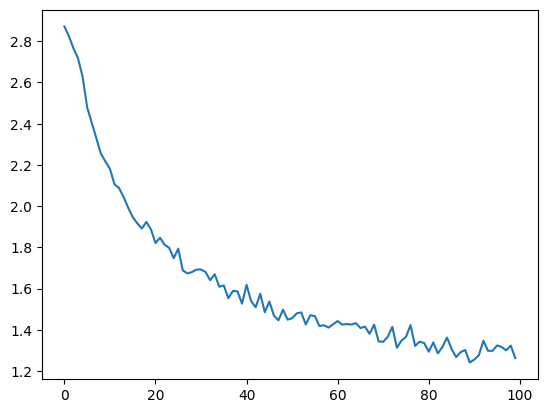

In [29]:
#Plot Loss

plt.figure()
plt.plot(all_losses)
plt.show()

#Save and Load Model:

In [39]:
#save model:
torch.save(rnn.state_dict(), "RNN_Name_Classification_Model_Parameters.pt")

In [40]:
#load model:
loaded_model = RNN(N_LETTERS, n_hidden, n_categories)
loaded_model.load_state_dict(torch.load("RNN_Name_Classification_Model_Parameters.pt"))
loaded_model.eval()

<ipython-input-40-a57927616d61>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("RNN_Name_Classification_Model_Parameters.pt"))


RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [41]:
def predict(input_line):
  print(f"\n> {input_line}")
  with torch.no_grad():
    line_tensor = line_to_tensor(input_line)
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output, hidden = loaded_model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    guess = category_from_output(output)
    print(f"Category: {guess}")

In [42]:
while True:
  sentence = input("Input: ")
  if sentence == "quit":
    break

  predict(sentence,)
  print()

Input: Albert

> Albert
Category: French

Input: Adler

> Adler
Category: German

Input: JIn

> JIn
Category: Chinese

Input: quit
